In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

### Ejercicio 1

In [99]:
datos = pd.read_excel('wind_data.xlsx')
print(datos)

       dia  regional wind  wind gap norte sur
0        1       8.000000            0.000000
1        2       8.346296            0.181523
2        3      10.062316            0.188643
3        4      10.791337            0.071085
4        5      10.754093            0.078442
...    ...            ...                 ...
3645  3646       8.642231           -0.869425
3646  3647       6.527408           -1.268447
3647  3648       6.230707           -1.149234
3648  3649       5.550882           -0.420431
3649  3650       6.545450            0.250088

[3650 rows x 3 columns]


In [100]:
datos['wind dif'] = datos['regional wind'].diff().shift(-1) #Si+1 - Si
print(datos)

       dia  regional wind  wind gap norte sur  wind dif
0        1       8.000000            0.000000  0.346296
1        2       8.346296            0.181523  1.716019
2        3      10.062316            0.188643  0.729021
3        4      10.791337            0.071085 -0.037244
4        5      10.754093            0.078442  0.017364
...    ...            ...                 ...       ...
3645  3646       8.642231           -0.869425 -2.114824
3646  3647       6.527408           -1.268447 -0.296701
3647  3648       6.230707           -1.149234 -0.679825
3648  3649       5.550882           -0.420431  0.994568
3649  3650       6.545450            0.250088       NaN

[3650 rows x 4 columns]


In [101]:
#datos_filtrados = datos.dropna(subset=['wind dif'])
datos['theta'] = 6 + 2 * np.cos(2 * np.pi * datos['dia'] / 365)

# Calcular theta(t_i) - S_i
datos['theta_minus_S'] = datos['theta'] - datos['regional wind']
data_filtrada = datos.dropna(subset=['wind dif', 'theta_minus_S'])

slope, intercept, r_value, p_value, std_err = stats.linregress(data_filtrada['theta_minus_S'], data_filtrada['wind dif'])

beta_1 = slope
beta_0 = intercept

print('beta_0:', beta_0)
print('beta_1:', beta_1)
print('std_err:', std_err)

beta_0: -0.01090490726175827
beta_1: 0.29874316789949523
std_err: 0.01177072911949767


In [102]:
kappa = (365 * beta_1)
print('kappa:', kappa)

kappa: 109.04125628331576


In [103]:
# Calcular los residuos
residuos = data_filtrada['wind dif'] - (slope * data_filtrada['theta_minus_S'] + intercept)

# Calcular el error estándar de los residuos
residual_std_err = np.std(residuos, ddof=1)  # ddof=1 para usar n-1 en la fórmula de la desviación estándar
print('residual_std_err:', residual_std_err)
# Calcular sigma
sigma = residual_std_err * np.sqrt(365)
print('sigma:', sigma)

residual_std_err: 0.8399264390386392
sigma: 16.046772086422457


In [104]:
datos['gap dif'] = datos['wind gap norte sur'] - datos['wind gap norte sur'].shift(1)
print(datos)

       dia  regional wind  wind gap norte sur  wind dif     theta  \
0        1       8.000000            0.000000  0.346296  7.999704   
1        2       8.346296            0.181523  1.716019  7.998815   
2        3      10.062316            0.188643  0.729021  7.997334   
3        4      10.791337            0.071085 -0.037244  7.995261   
4        5      10.754093            0.078442  0.017364  7.992596   
...    ...            ...                 ...       ...       ...   
3645  3646       8.642231           -0.869425 -2.114824  7.995261   
3646  3647       6.527408           -1.268447 -0.296701  7.997334   
3647  3648       6.230707           -1.149234 -0.679825  7.998815   
3648  3649       5.550882           -0.420431  0.994568  7.999704   
3649  3650       6.545450            0.250088       NaN  8.000000   

      theta_minus_S   gap dif  
0         -0.000296       NaN  
1         -0.347482  0.181523  
2         -2.064982  0.007120  
3         -2.796076 -0.117558  
4         -

In [105]:
datos_filtrados_gap = datos.dropna(subset=['gap dif'])

slope_gap, intercept_gap, r_value_gap, p_value_gap, std_err_gap = stats.linregress(datos_filtrados_gap['wind gap norte sur'], datos_filtrados_gap['gap dif'])

beta_1_gap = slope_gap
beta_0_gap = intercept_gap

print('beta_0:', beta_0_gap)
print('beta_1:', beta_1_gap)

beta_0: -0.004013223850057093
beta_1: 0.1325505861738276


In [106]:
beta = 365 * beta_1_gap
beta

48.38096395344707

In [107]:
# Calcular los residuos
residuos_gap = datos_filtrados_gap['gap dif'] - (slope_gap * datos_filtrados_gap['wind gap norte sur'] + intercept_gap)

# Calcular el error estándar de los residuos
residual_gap_std_err = np.std(residuos_gap, ddof=1)  # ddof=1 para usar n-1 en la fórmula de la desviación estándar
print('residual_std_err:', residual_gap_std_err)
# Calcular sigma
gamma = residual_gap_std_err * np.sqrt(365)
print('gamma:', gamma)

residual_std_err: 0.5282417805574243
gamma: 10.092045047222316


## Ejercicio 2

In [108]:
def theta(t):
    return 6 + 2 * np.cos(2 * np.pi * t / 365)

In [109]:
def simulacion (n_days):
    S = np.zeros(n_days)
    D = np.zeros(n_days)

    # Valores iniciales (suponemos que S_0 y D_0 son conocidos o se dan como 0)
    S[0] = np.mean(datos['regional wind'])
    D[0] = 0

    for i in range(1, n_days):
        S[i] = S[i - 1] + kappa * (theta(i) - S[i - 1]) * 1/365 + sigma * np.sqrt(1/365) * np.random.normal(0, 1)
            
        D[i] = D[i-1] - beta * D[i-1] * 1/365 + gamma * np.sqrt(1/365) * np.random.normal(0, 1)

    return S, D

In [110]:
S, D = simulacion(3650)

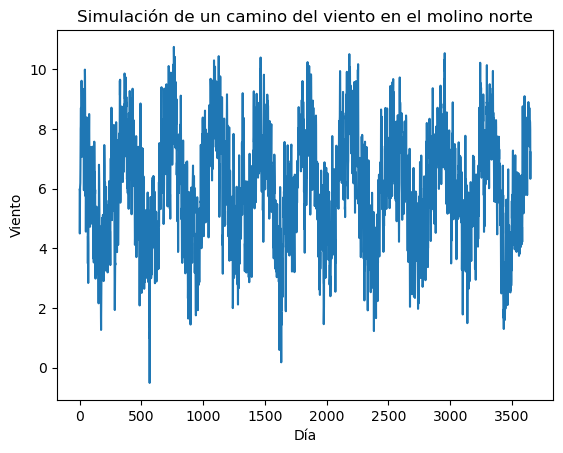

In [111]:
#Viento en molino norte
S_norte = S+D/2

plt.plot(S_norte)
plt.title('Simulación de un camino del viento en el molino norte')
plt.xlabel('Día')
plt.ylabel('Viento')
plt.show()

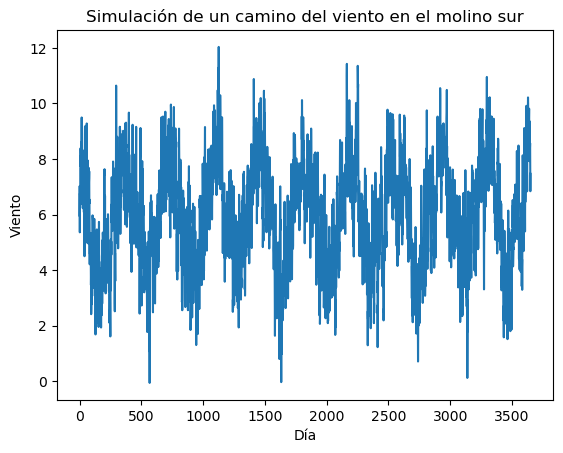

In [112]:
S_sur = S-D/2

plt.plot(S_sur)
plt.title('Simulación de un camino del viento en el molino sur')
plt.xlabel('Día')
plt.ylabel('Viento')
plt.show()

Media del viento simulado: 5.999848363723782
Desviación estándar del viento simulado: 1.7641838332114566
Media del viento histórico: 5.964442822277723
Desviación estándar del viento histórico: 1.8032133987250791
Media de la diferencia simulada: 0.023811981488365098
Desviación estándar de la diferencia simulada: 1.0840153851444003
Media de la diferencia histórica: 0.03078554102481403
Desviación estándar de la diferencia histórica: 1.0614721182882032


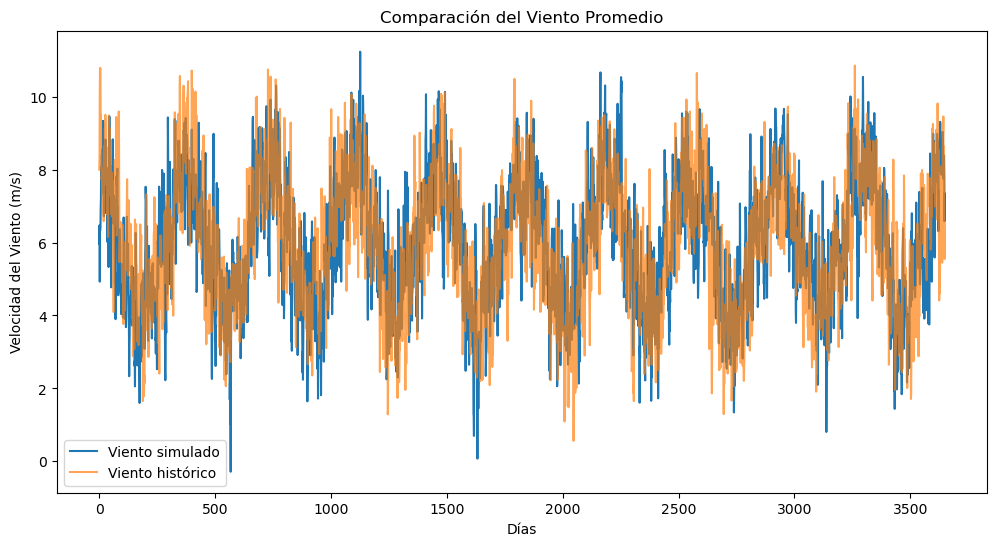

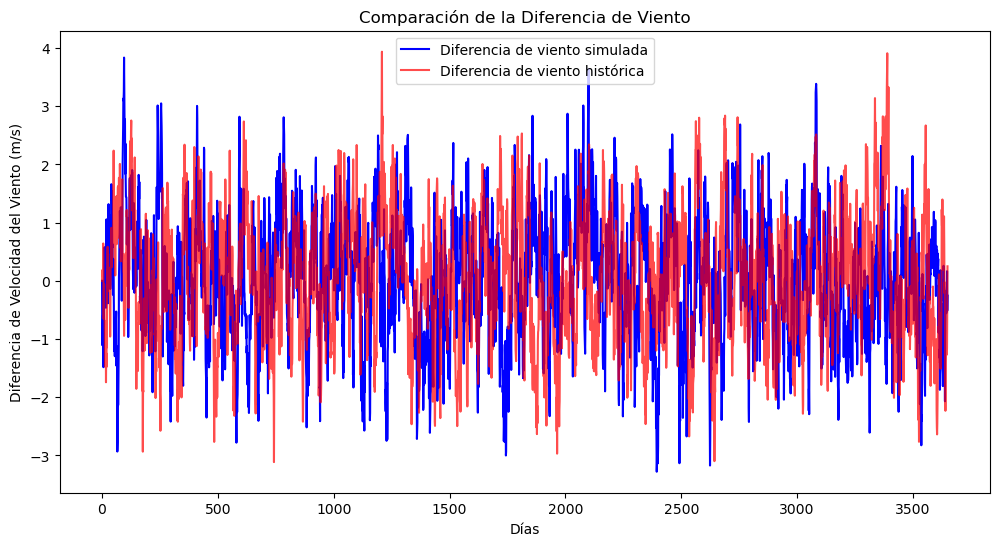

In [113]:
# Supongamos que tienes datos históricos de 'wind' y 'wind dif'
historical_wind = datos['regional wind']
historical_wind_dif = datos['wind gap norte sur']

# Comparación de la media y desviación estándar
print(f"Media del viento simulado: {np.mean(S)}")
print(f"Desviación estándar del viento simulado: {np.std(S)}")
print(f"Media del viento histórico: {np.mean(historical_wind)}")
print(f"Desviación estándar del viento histórico: {np.std(historical_wind)}")

# Similar para la diferencia de viento
print(f"Media de la diferencia simulada: {np.mean(D)}")
print(f"Desviación estándar de la diferencia simulada: {np.std(D)}")
print(f"Media de la diferencia histórica: {np.mean(historical_wind_dif)}")
print(f"Desviación estándar de la diferencia histórica: {np.std(historical_wind_dif)}")

# Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(S, label='Viento simulado')
plt.plot(historical_wind, label='Viento histórico', alpha=0.7)
plt.title('Comparación del Viento Promedio')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(D, label='Diferencia de viento simulada', color='blue')
plt.plot(historical_wind_dif, label='Diferencia de viento histórica', color='red', alpha=0.7)
plt.title('Comparación de la Diferencia de Viento')
plt.xlabel('Días')
plt.ylabel('Diferencia de Velocidad del Viento (m/s)')
plt.legend()
plt.show()


## Ejercicio 3


In [114]:
n_sim = 5000

In [115]:
def calcular_VAN(S, D, k, n_days, costo_rep):
    cashflow = np.zeros(n_days)

    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    roturas_norte = np.zeros(n_days)
    roturas_sur = np.zeros(n_days)

    apagados_norte = np.zeros(n_days)
    apagados_sur = np.zeros(n_days)

    for i in range(1, n_days):
        if estado_molino_norte[i-1] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto
                roturas_norte[i] = 1
                cashflow[i] -= costo_rep  # Costo de reparación

        if estado_molino_sur[i-1] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto
                roturas_sur[i] = 1
                cashflow[i] -= costo_rep  # Costo de reparación

        if  estado_molino_norte[i] == 1:
            if viento_norte[i] > k:
                estado_molino_norte[i] = 0 #si pasa umbral se apaga
                apagados_norte[i] = 1
                cashflow[i] -= 1000  # Costo de apagar el molino
            elif viento_norte[i] <= k:
                estado_molino_norte[i] = 1 #si esta por debajo de umbral se enciende

        if estado_molino_sur[i] == 1:
            if  viento_sur[i] > k:
                estado_molino_sur[i] = 0
                apagados_sur[i] = 1
                cashflow[i] -= 1000  # Costo de apagar el molino
            elif viento_sur[i] <= k:
                estado_molino_sur[i] = 1

        if estado_molino_norte[i] == 1:
            cashflow[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            cashflow[i] += 1000 * viento_sur[i]
    
    descuentos = np.exp(-0.05 * np.arange(n_days) / 365)
    VAN_calc = np.sum(cashflow * descuentos)

    return VAN_calc, cashflow, estado_molino_norte, estado_molino_sur, roturas_norte, roturas_sur, apagados_norte, apagados_sur

In [116]:
S, D = simulacion(365)

VAN_calculado, cashflow, estado_molino_norte, estado_molino_sur, roturas_molino_norte, roturas_molino_sur, apagados_molino_norte, apagados_molino_sur = calcular_VAN(S, D, 10, 365, 200000)
print(f"El Valor Actual Neto (VAN) del proyecto es: {VAN_calculado:.2f}")
print(f"Número de roturas del molino norte: {np.sum(roturas_molino_norte)}")
print(f"Número de roturas del molino sur: {np.sum(roturas_molino_sur)}")
print(f"Número de apagados del molino norte: {np.sum(apagados_molino_norte)}")
print(f"Número de apagados del molino sur: {np.sum(apagados_molino_sur)}")


El Valor Actual Neto (VAN) del proyecto es: 397993.74
Número de roturas del molino norte: 8.0
Número de roturas del molino sur: 11.0
Número de apagados del molino norte: 12.0
Número de apagados del molino sur: 3.0


## Ejercicio 4

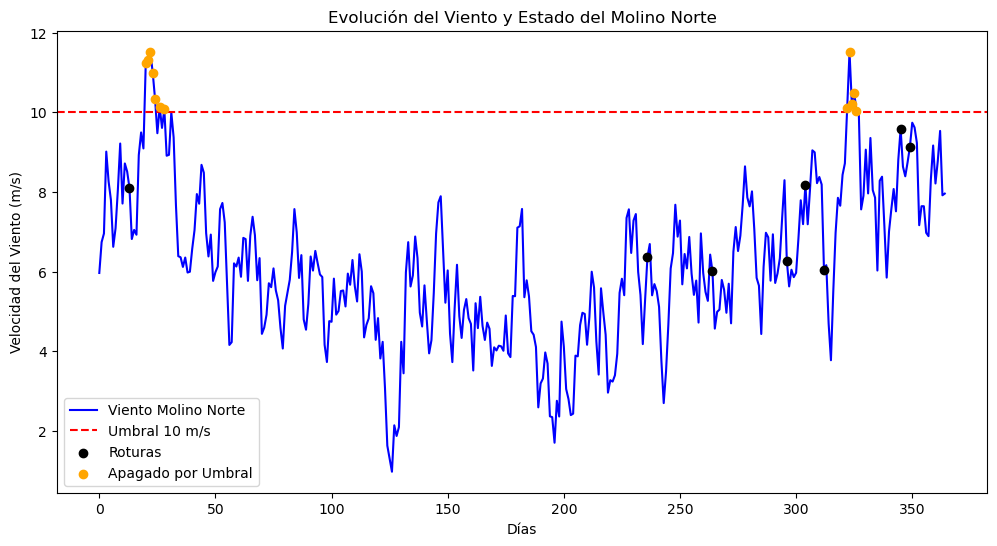

In [117]:
# Días
dias = np.arange(365)
s_norte = S + D/2
s_sur = S - D/2

# Gráfico del viento simulado y umbral
plt.figure(figsize=(12, 6))

# Viento en el Molino Norte
plt.plot(dias, s_norte, label='Viento Molino Norte', color='blue')

# Umbral de apagado
plt.axhline(10, color='red', linestyle='--', label=f'Umbral {10} m/s')

# Marcar días con roturas
plt.scatter(dias[roturas_molino_norte == 1], s_norte[roturas_molino_norte == 1], color='black', label='Roturas', zorder=5)

# Marcar días en los que el molino está apagado
plt.scatter(dias[(s_norte > 10) & (estado_molino_norte == 0)], s_norte[(s_norte > 10) & (estado_molino_norte == 0)], 
            color='orange', label='Apagado por Umbral', zorder=5)

plt.title('Evolución del Viento y Estado del Molino Norte')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()


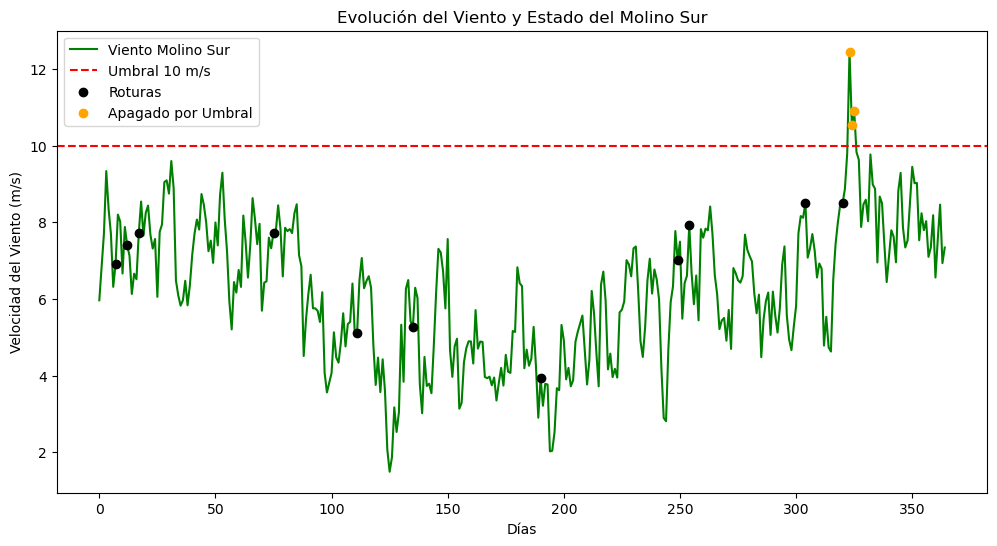

In [118]:
# Gráfico del viento simulado y umbral
plt.figure(figsize=(12, 6))

# Viento en el Molino Norte
plt.plot(dias, s_sur, label='Viento Molino Sur', color='green')

# Umbral de apagado
plt.axhline(10, color='red', linestyle='--', label=f'Umbral {10} m/s')

# Marcar días con roturas
plt.scatter(dias[roturas_molino_sur == 1], s_sur[roturas_molino_sur == 1], color='black', label='Roturas', zorder=5)

# Marcar días en los que el molino está apagado
plt.scatter(dias[(s_sur > 10) & (estado_molino_sur == 0)], s_sur[(s_sur > 10) & (estado_molino_sur == 0)], 
            color='orange', label='Apagado por Umbral', zorder=5)

plt.title('Evolución del Viento y Estado del Molino Sur')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()


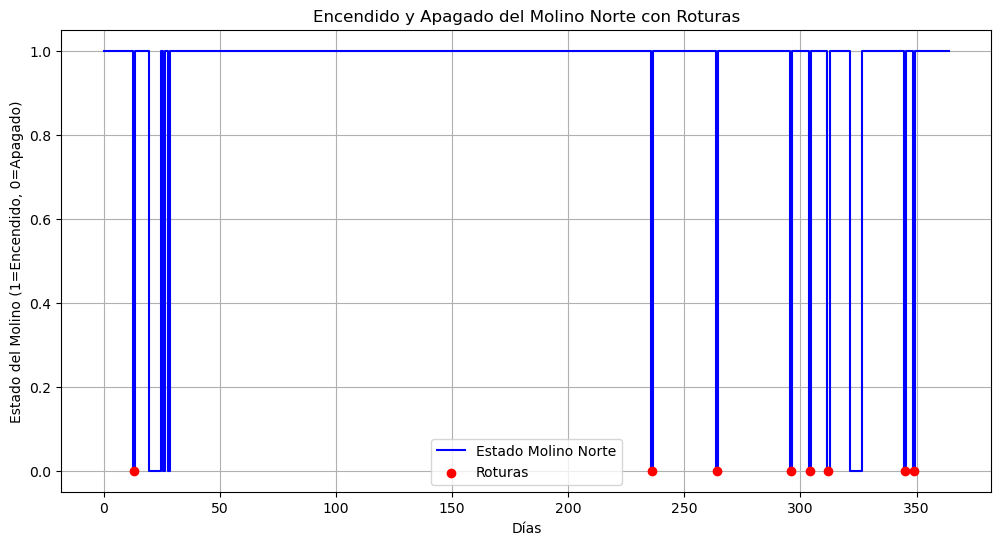

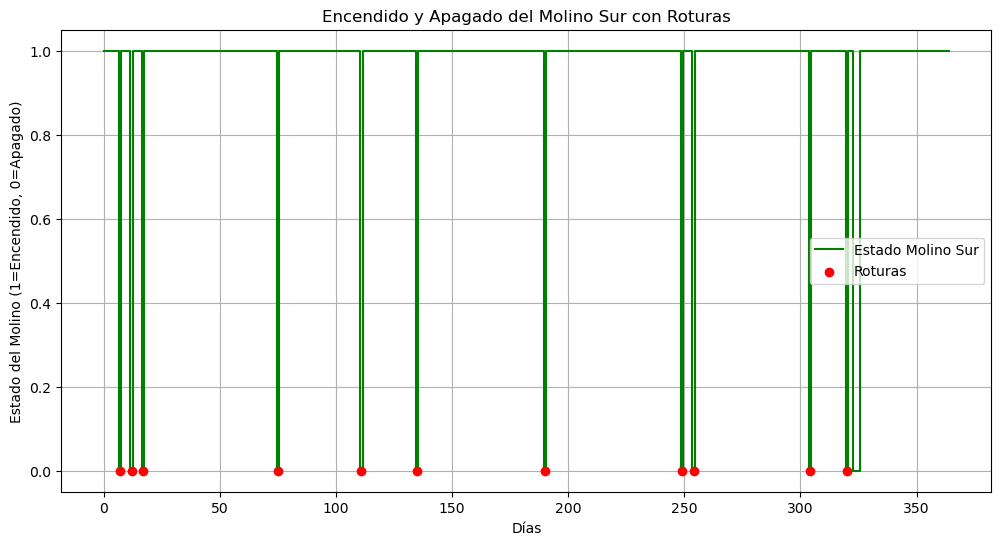

In [119]:
import matplotlib.pyplot as plt

# Días
dias = np.arange(365)

# Gráfico del estado del Molino Norte
plt.figure(figsize=(12, 6))

# Estado del molino Norte (1=Encendido, 0=Apagado)
plt.step(dias, estado_molino_norte, label='Estado Molino Norte', color='blue', where='mid')

# Marcar roturas en el molino Norte
plt.scatter(dias[roturas_molino_norte == 1], estado_molino_norte[roturas_molino_norte == 1], color='red', label='Roturas', zorder=5)

plt.title('Encendido y Apagado del Molino Norte con Roturas')
plt.xlabel('Días')
plt.ylabel('Estado del Molino (1=Encendido, 0=Apagado)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico del estado del Molino Sur
plt.figure(figsize=(12, 6))

# Estado del molino Sur (1=Encendido, 0=Apagado)
plt.step(dias, estado_molino_sur, label='Estado Molino Sur', color='green', where='mid')

# Marcar roturas en el molino Sur
plt.scatter(dias[roturas_molino_sur == 1], estado_molino_sur[roturas_molino_sur == 1], color='red', label='Roturas', zorder=5)

plt.title('Encendido y Apagado del Molino Sur con Roturas')
plt.xlabel('Días')
plt.ylabel('Estado del Molino (1=Encendido, 0=Apagado)')
plt.legend()
plt.grid(True)
plt.show()


## Ejercicio 5

In [120]:
def calcular_umbral_optimo(umbral_k, costo_reparacion):
    VANs_por_umbral = []
    medias_VAN = []
    errores_VAN = []
    best_van = -np.inf
    best_k = None

    for k in umbral_k:
        VANs = np.zeros(n_sim)
    
        for j in range(n_sim):
            S, D = simulacion(365)
            VAN_calculado, _, _, _, _, _, _, _ = calcular_VAN(S, D, k, 365, costo_reparacion)
        
            VANs[j] = VAN_calculado

        media_VAN = np.mean(VANs)
        error_VAN = np.std(VANs) / np.sqrt(n_sim)

        medias_VAN.append(media_VAN)
        errores_VAN.append(error_VAN)

        if media_VAN > best_van:
            best_van = media_VAN
            best_k = k

        VANs_por_umbral.append(VANs)

    return best_k, best_van, medias_VAN, errores_VAN, VANs_por_umbral

In [121]:
umbral_k = np.arange(1, 14, 1)
best_k, best_van, medias_VAN, errores_VAN, VANs_por_umbral = calcular_umbral_optimo(umbral_k, 200000)

print('umbral_k:', umbral_k)
print('medias_VAN:', medias_VAN)
print('errores_VAN:', errores_VAN)
print('best_k:', best_k)
print('best_van:', best_van)

umbral_k: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
medias_VAN: [-720635.2094872046, -705946.9683033762, -638585.4302110678, -460564.70087434637, -187055.0780074444, 89876.84605831688, 323761.6481743168, 420470.9808128204, 419953.47926069825, 393916.2856934668, 409029.8956169402, 411164.272272947, 403377.6101641604]
errores_VAN: [703.0839633106456, 876.8785723137811, 1603.1324840261336, 2945.7754129088703, 4752.636838259298, 6505.644305195982, 8490.120119890022, 10052.992177864327, 11316.52499400788, 11729.729071953554, 11950.074697794056, 12068.028600573527, 11811.484955300386]
best_k: 8
best_van: 420470.9808128204


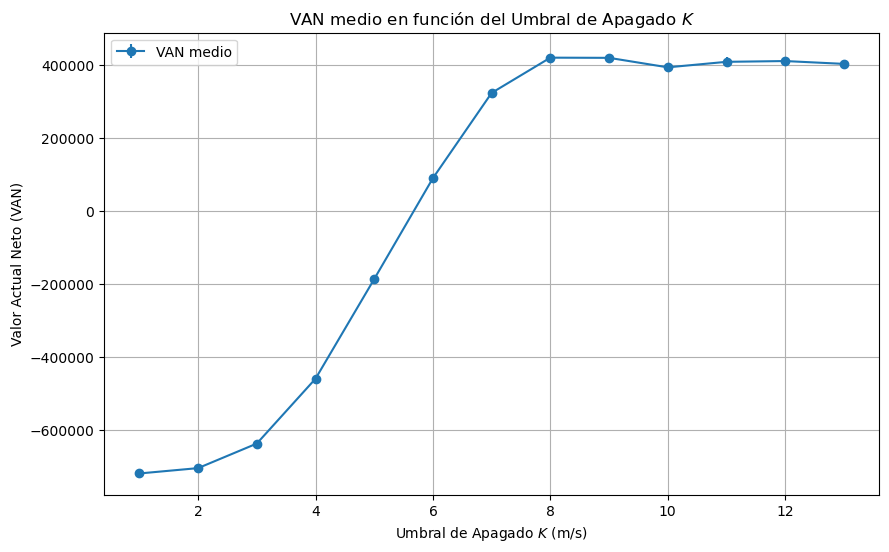

In [122]:
plt.figure(figsize=(10, 6))
plt.errorbar(umbral_k, medias_VAN, yerr=errores_VAN, fmt='-o', label='VAN medio')
plt.title('VAN medio en función del Umbral de Apagado $K$')
plt.xlabel('Umbral de Apagado $K$ (m/s)')
plt.ylabel('Valor Actual Neto (VAN)')
plt.grid(True)
plt.legend()
plt.show()

## Ejercicio 6

In [123]:
print('El valor optimo del umbral es: ', best_k)

El valor optimo del umbral es:  8


## Ejercicio 7

In [124]:
def calcular_VAN_ingenuo(S, D, n_days):
    cashflow = np.zeros(n_days)

    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    roturas_norte = np.zeros(n_days)
    roturas_sur = np.zeros(n_days)

    for i in range(1, n_days):
        if estado_molino_norte[i-1] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto
                roturas_norte[i] = 1
                cashflow[i] -= 200000  # Costo de reparación

        if estado_molino_sur[i-1] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto
                roturas_sur[i] = 1
                cashflow[i] -= 200000  # Costo de reparación

        if estado_molino_norte[i] == 1:
            cashflow[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            cashflow[i] += 1000 * viento_sur[i]
    
    descuentos = np.exp(-0.05 * np.arange(n_days) / 365)
    VAN = np.sum(cashflow * descuentos)

    return VAN, cashflow, estado_molino_norte, estado_molino_sur, roturas_norte, roturas_sur

In [125]:
VANs_ingenuo = np.zeros(n_sim)

for i in range(n_sim):
    S, D = simulacion(365)
    VAN_calculado_ingenuo, cashflow_ingenuo, estado_molino_norte_ingenuo, estado_molino_sur_ingenuo, roturas_molino_norte_ingenuo, roturas_molino_sur_ingenuo = calcular_VAN_ingenuo(S, D, 365)
    VANs_ingenuo[i] = VAN_calculado_ingenuo

media_VAN_ingenuo = np.mean(VANs_ingenuo)
error_VAN_ingenuo = np.std(VANs_ingenuo) / np.sqrt(n_sim)

In [126]:
print('Ganancia con el umbral optimo: ', round(best_van, 2))
print('Ganancia ingenua: ', round(media_VAN_ingenuo, 2))
print('Diferencia de ganancia: ', round(best_van - media_VAN_ingenuo, 2))

Ganancia con el umbral optimo:  420470.98
Ganancia ingenua:  412017.13
Diferencia de ganancia:  8453.85


## Ejercicio 8

Ingreso total promedio en agosto: 85146.21672107257
Mediana del ingreso total en agosto: 84294.67367643776
Desviación estándar del ingreso total en agosto: 188490.97100181953


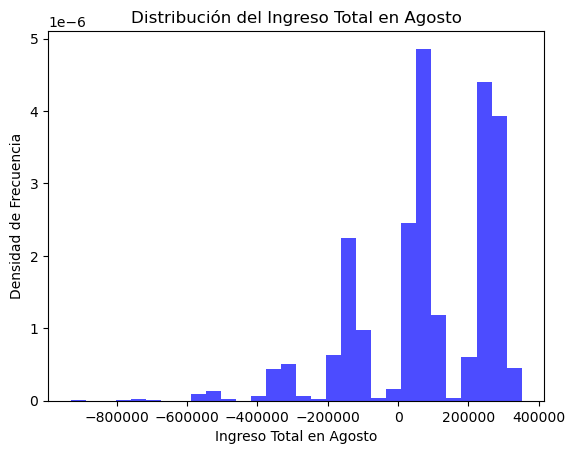

In [127]:
# Definir los días correspondientes al mes de agosto (del día 213 al 242, ya que Python excluye el último índice)
dias_agosto = range(213, 243)

# Arreglo para almacenar el ingreso total de agosto en cada simulación
ingresos_agosto = np.zeros(n_sim)

for j in range(n_sim):
    # Simular los datos para todo el año
    S, D = simulacion(365)
    
    # Calcular el flujo de caja (cashflow) con el umbral óptimo de operación 'best_k'
    _, cashflow_sim, _, _, _, _, _, _ = calcular_VAN(S, D, best_k, 365, 200000)
    
    # Calcular el ingreso total de agosto sumando los cashflows de los días de agosto
    ingresos_agosto[j] = np.sum(cashflow_sim[dias_agosto])

# Estadísticas descriptivas
media_ingreso = np.mean(ingresos_agosto)
mediana_ingreso = np.median(ingresos_agosto)
desviacion_ingreso = np.std(ingresos_agosto) 

print(f"Ingreso total promedio en agosto: {media_ingreso}")
print(f"Mediana del ingreso total en agosto: {mediana_ingreso}")
print(f"Desviación estándar del ingreso total en agosto: {desviacion_ingreso}")

# Graficar el histograma
plt.hist(ingresos_agosto, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Distribución del Ingreso Total en Agosto')
plt.xlabel('Ingreso Total en Agosto')
plt.ylabel('Densidad de Frecuencia')
plt.show()


## Ejercicio 9

In [128]:
# Número medio de roturas por año que sufre el molino bajo la estrategia óptima
cant_roturas_norte_opt = []
cant_roturas_sur_opt = []

cant_roturas_norte_ing = []
cant_roturas_sur_ing = []

for i in range(n_sim):
    S, D = simulacion(365)
    _, _, _, _, roturas_molino_norte_opt, roturas_molino_sur_opt, _, _ = calcular_VAN(S, D, best_k, 365, 200000)
    _, _, _, _, roturas_molino_norte_ing, roturas_molino_sur_ing= calcular_VAN_ingenuo(S, D, 365)

    roturas_norte_opt = np.sum(roturas_molino_norte_opt)
    roturas_sur_opt = np.sum(roturas_molino_sur_opt)

    roturas_norte_ing = np.sum(roturas_molino_norte_ing)
    roturas_sur_ing = np.sum(roturas_molino_sur_ing)

    cant_roturas_norte_opt.append(roturas_norte_opt)
    cant_roturas_sur_opt.append(roturas_sur_opt)

    cant_roturas_norte_ing.append(roturas_norte_ing)
    cant_roturas_sur_ing.append(roturas_sur_ing)

media_roturas_norte_opt = np.mean(cant_roturas_norte_opt)
error_roturas_norte_opt = np.std(cant_roturas_norte_opt) / np.sqrt(1000)

media_roturas_sur_opt = np.mean(cant_roturas_sur_opt)
error_roturas_sur_opt = np.std(cant_roturas_sur_opt) / np.sqrt(1000)

media_roturas_norte_ing = np.mean(cant_roturas_norte_ing)
error_roturas_norte_ing = np.std(cant_roturas_norte_ing) / np.sqrt(1000)

media_roturas_sur_ing = np.mean(cant_roturas_sur_ing)
error_roturas_sur_ing = np.std(cant_roturas_sur_ing) / np.sqrt(1000)

print ('Número Medio de Roturas del Molino Norte bajo estrategia óptima: ', round(media_roturas_norte_opt))
print('Error en el número medio de roturas del Molino Norte bajo estrategia óptima: ', error_roturas_norte_opt)	
print ('Número Medio de Roturas del Molino Sur bajo estrategia óptima: ', round(media_roturas_sur_opt))
print('Error en el número medio de roturas del Molino Sur bajo estrategia óptima: ', error_roturas_sur_opt)

print ('Número Medio de Roturas del Molino Norte bajo estrategia ingenua: ', round(media_roturas_norte_ing))
print('Error en el número medio de roturas del Molino Norte bajo estrategia ingenua: ', error_roturas_norte_ing)
print ('Número Medio de Roturas del Molino Sur bajo estrategia ingenua: ', round(media_roturas_sur_ing))
print('Error en el número medio de roturas del Molino Sur bajo estrategia ingenua: ', error_roturas_sur_ing)

Número Medio de Roturas del Molino Norte bajo estrategia óptima:  7
Error en el número medio de roturas del Molino Norte bajo estrategia óptima:  0.07953282969943923
Número Medio de Roturas del Molino Sur bajo estrategia óptima:  7
Error en el número medio de roturas del Molino Sur bajo estrategia óptima:  0.07974300696612838
Número Medio de Roturas del Molino Norte bajo estrategia ingenua:  9
Error en el número medio de roturas del Molino Norte bajo estrategia ingenua:  0.09444670963035187
Número Medio de Roturas del Molino Sur bajo estrategia ingenua:  10
Error en el número medio de roturas del Molino Sur bajo estrategia ingenua:  0.09391961477774492


## Ejercicio 10

In [129]:
inactivo_norte_sim = []
inactivo_sur_sim = []

for i in range(n_sim):
    S, D = simulacion(365)
    _, _, estado_molino_norte_inactivo, estado_molino_sur_inactivo, _, _, _, _ = calcular_VAN(S, D, best_k, 365, 200000)

    total_inactivo_norte = np.count_nonzero(estado_molino_norte_inactivo == 0)
    total_inactivo_sur = np.count_nonzero(estado_molino_sur_inactivo == 0)

    inactivo_norte_sim.append(total_inactivo_norte)
    inactivo_sur_sim.append(total_inactivo_sur)

media_inactivo_norte = np.mean(inactivo_norte_sim)
error_inactivo_norte = np.std(inactivo_norte_sim) / np.sqrt(n_sim)

media_inactivo_sur = np.mean(inactivo_sur_sim)
error_inactivo_sur = np.std(inactivo_sur_sim) / np.sqrt(n_sim)

print('Numero de dias promedio por año de inactividad del molino norte:', round(media_inactivo_norte))
print('Error en el numero de dias promedio por año de inactividad del molino norte:', error_inactivo_norte)
print('Numero de dias promedio por año de inactividad del molino sur:', round(media_inactivo_sur))
print('Error en el numero de dias promedio por año de inactividad del molino sur:', error_inactivo_sur)

Numero de dias promedio por año de inactividad del molino norte: 62
Error en el numero de dias promedio por año de inactividad del molino norte: 0.17735865743740842
Numero de dias promedio por año de inactividad del molino sur: 62
Error en el numero de dias promedio por año de inactividad del molino sur: 0.17604316377525142


## Ejercicio 11

In [130]:
estado_inactivos_190_sim = []

for i in range(n_sim):
    S, D = simulacion(365)
    _, _, estado_molino_norte, estado_molino_sur, _, _, _, _ = calcular_VAN(S, D, best_k, 365, 200000)
    # Verificar si ambos molinos están inactivos el día 190
    estado_inactivos_190 = (estado_molino_norte[190] == 0) and (estado_molino_sur[190] == 0)
    estado_inactivos_190_sim.append(estado_inactivos_190)

# Calcular la probabilidad de que ambos molinos estén inactivos el 9 de julio
probabilidad_inactivos_190 = np.mean(estado_inactivos_190_sim)

# Calcular el error estándar de Monte Carlo
error_mc = np.std(estado_inactivos_190_sim) / np.sqrt(n_sim)

print('Probabilidad de que ambos molinos estén inactivos el 9 de julio:', probabilidad_inactivos_190)
print('Error estándar de Monte Carlo:', error_mc)

Probabilidad de que ambos molinos estén inactivos el 9 de julio: 0.0006
Error estándar de Monte Carlo: 0.00034630622287218577


In [131]:
proba_sim = []

for i in range(n_sim):
    S, D = simulacion(365)
    _, _, estado_molino_norte, estado_molino_sur, _, _, _, _ = calcular_VAN(S, D, best_k, 365, 200000)

    estado_inactivos_j = 0
    for j in range(365):
        estado_inactivos_j += (estado_molino_norte[j] == 0) and (estado_molino_sur[j] == 0)
    proba_inactivo = estado_inactivos_j / 365
    proba_sim.append(proba_inactivo)

probabilidad_inactivos = np.mean(proba_sim)

error = np.std(proba_sim) / np.sqrt(n_sim)

print('Probabilidad de que ambos molinos estén inactivos algun dia:', probabilidad_inactivos)
print('Error estándar de Monte Carlo:', error)

Probabilidad de que ambos molinos estén inactivos algun dia: 0.10152164383561643
Error estándar de Monte Carlo: 0.0003791130097777884


## Ejercicio 12

In [132]:
def ingreso_por_molino(S, D, k, n_days):
    cashflow_norte = np.zeros(n_days)
    cashflow_sur = np.zeros(n_days)

    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    roturas_norte = np.zeros(n_days)
    roturas_sur = np.zeros(n_days)

    apagados_norte = np.zeros(n_days)
    apagados_sur = np.zeros(n_days)

    for i in range(1, n_days):
        if estado_molino_norte[i-1] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto
                roturas_norte[i] = 1
                cashflow_norte[i] -= 200000  # Costo de reparación

        if estado_molino_sur[i-1] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto
                roturas_sur[i] = 1
                cashflow_sur[i] -= 200000  # Costo de reparación

        if estado_molino_norte[i] == 1:
            if viento_norte[i] > k:
                estado_molino_norte[i] = 0 #si pasa umbral se apaga
                apagados_norte[i] = 1
                cashflow_norte[i] -= 1000  # Costo de apagar el molino
            elif  viento_norte[i] <= k:
                estado_molino_norte[i] = 1 #si esta por debajo de umbral se enciende

        if estado_molino_sur[i] == 1:
            if viento_sur[i] > k:
                estado_molino_sur[i] = 0
                apagados_sur[i] = 1
                cashflow_sur[i] -= 1000  # Costo de apagar el molino
            elif viento_sur[i] <= k:
                estado_molino_sur[i] = 1

        if estado_molino_norte[i] == 1:
            cashflow_norte[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            cashflow_sur[i] += 1000 * viento_sur[i]

    return cashflow_norte, cashflow_sur

In [134]:
cashflows_norte = []
cashflows_sur = []

for i in range(n_sim):
    S, D = simulacion(365)
    cashflow_norte, cashflow_sur = ingreso_por_molino(S, D, best_k, 365)
    cashflows_norte.append(cashflow_norte)
    cashflows_sur.append(cashflow_sur)

media_cashflows_norte = np.mean(cashflows_norte, axis=0)
error_cashflows_norte = np.std(cashflows_norte, axis=0) / np.sqrt(n_sim)

media_cashflows_sur = np.mean(cashflows_sur, axis=0)
error_cashflows_sur = np.std(cashflows_sur, axis=0) / np.sqrt(n_sim)

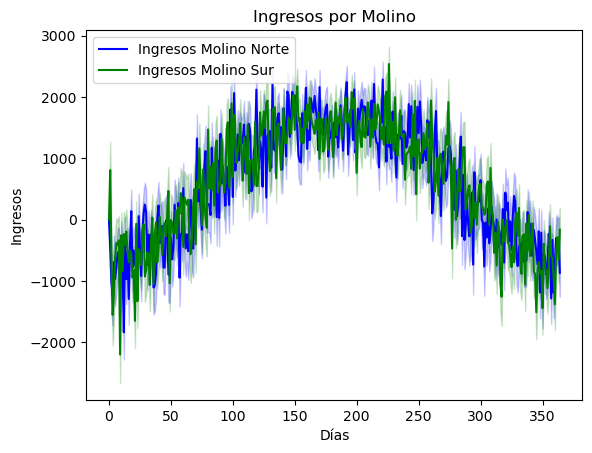

In [135]:
plt.plot(media_cashflows_norte, label='Ingresos Molino Norte', color='blue')
plt.fill_between(np.arange(365), media_cashflows_norte - error_cashflows_norte, media_cashflows_norte + error_cashflows_norte, color='blue', alpha=0.2)
plt.plot(media_cashflows_sur, label='Ingresos Molino Sur', color='green')
plt.fill_between(np.arange(365), media_cashflows_sur - error_cashflows_sur, media_cashflows_sur + error_cashflows_sur, color='green', alpha=0.2)
plt.title('Ingresos por Molino')
plt.xlabel('Días')
plt.ylabel('Ingresos')
plt.legend()
plt.show()


In [136]:
correlacion = np.corrcoef(cashflows_norte, cashflows_sur)[0, 1]
print(correlacion)

0.17121890324159977


A corto plazo, no pareciera haber una correlación. Pero a largo plazo si existe una correlacion, en la cual ambas suben  medida que avanzan los dias hasta alcanzar un pico en la mitad de año aproximadamente, donde pasa a decrecer a medida que avanzan los dias

## Ejercicio 13

In [137]:
costo_rep = np.arange(100000, 300000, 10000)
van_por_umbral = []
error_por_umbral = []
# Calcular el VAN para diferentes umbrales
resultados = []
for costo in costo_rep:
    for i in range(n_sim):
        S, D = simulacion(365)
        VAN, _, _, _, _, _, _, _ = calcular_VAN(S, D, best_k, 365, costo)
        resultados.append(VAN)

    media_resultados = np.mean(resultados)
    error_resultados = np.std(resultados) / np.sqrt(n_sim)

    van_por_umbral.append(media_resultados)
    error_por_umbral.append(error_resultados)

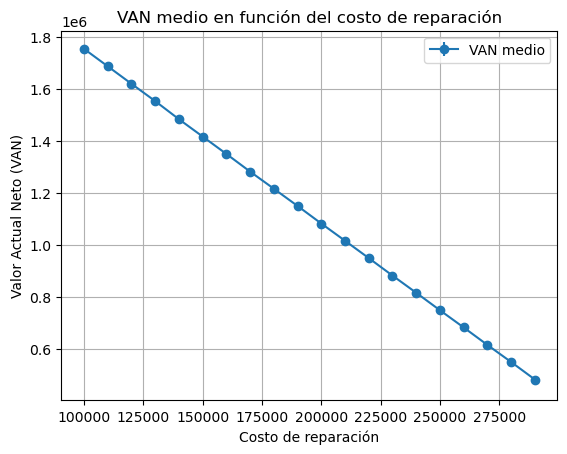

In [138]:
plt.errorbar(costo_rep, van_por_umbral, yerr=error_por_umbral, fmt='-o', label='VAN medio')
plt.title('VAN medio en función del costo de reparación')
plt.xlabel('Costo de reparación')
plt.ylabel('Valor Actual Neto (VAN)')
plt.grid(True)
plt.legend()
plt.show()

In [139]:
umbral_k_2 = np.arange(1, 14, 1)
#costo_reparacion = 250000
best_k_2, best_van_2, medias_VAN_2, errores_VAN_2, VANs_por_umbral_2 = calcular_umbral_optimo(umbral_k, 250000)
print('umbral_k:', umbral_k_2)
print('medias_VAN:', medias_VAN_2)
print('errores_VAN:', errores_VAN_2)
print('best_k:', best_k_2)
print('best_van:', best_van_2)

umbral_k: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
medias_VAN: [-722765.8218197895, -710368.5155934946, -655721.1228072883, -512951.8300495019, -335258.4231350347, -186524.4368461192, -156551.67239675226, -268645.8237573614, -401329.66355603735, -477957.4430076256, -497710.274881954, -518541.0374934013, -486696.2032586239]
errores_VAN: [851.0561608887558, 1100.3416740812827, 2027.3276766388287, 3703.685538864153, 5946.610923544934, 8166.200200670019, 10611.924924376412, 12602.131245967968, 13894.254506470455, 14435.454231432583, 14565.260911383992, 14755.309824134583, 14904.206481022717]
best_k: 7
best_van: -156551.67239675226


## Ejercicio 14

In [140]:
def calcular_theta(t, media_base):
    return media_base + 2 * np.cos(2 * np.pi * t / 365)

def simulacion2(n_days, media_base):
    S2 = np.zeros(n_days)
    D2 = np.zeros(n_days)

    # Valores iniciales
    S2[0] = np.mean(datos['regional wind'])  # Ajustar a los datos históricos
    D2[0] = 0  # Inicialización de la diferencia de viento

    for i in range(1, n_days):
        S2[i] = S2[i - 1] + kappa * (calcular_theta(i, media_base) - S2[i - 1]) * (1/365) + sigma * np.sqrt(1/365) * np.random.normal(0, 1)
        D2[i] = D2[i-1] - beta * D2[i-1] * (1/365) + gamma * np.sqrt(1/365) * np.random.normal(0, 1)

    return S2, D2

In [141]:
valores_media_base = np.arange(4, 12, 0.5)
van_por_valor = []
error_por_valor = []
# Calcular el VAN para diferentes umbrales
resultados = []

for valor in valores_media_base:
    for i in range(n_sim):
        S, D = simulacion2(365, valor)
        VAN, _, _, _, _, _, _, _ = calcular_VAN(S, D, best_k, 365, 200000)
        resultados.append(VAN)

    media_resultados = np.mean(resultados)
    error_resultados = np.std(resultados) / np.sqrt(n_sim)

    van_por_valor.append(media_resultados)
    error_por_valor.append(error_resultados)

print(van_por_valor)
print(error_por_valor)

[898326.5372039747, 872224.3418310552, 827288.2052235637, 762083.2118588692, 689902.7398031636, 611066.6309993573, 530777.8071313701, 449957.95707257034, 370038.14712919685, 290440.59639901243, 214888.1947984502, 144181.85418539398, 79324.95678896735, 22063.22535409574, -28660.541507789625, -72917.36721894302]
[8339.863101800607, 8720.471845877122, 9082.297202012145, 9444.739943370942, 9787.128428844317, 10150.041274607403, 10488.085742759118, 10812.945087018565, 11101.150033265507, 11381.319355940212, 11601.461616790233, 11750.745830444705, 11837.813192984004, 11843.650471464454, 11792.436459814504, 11693.119574088067]


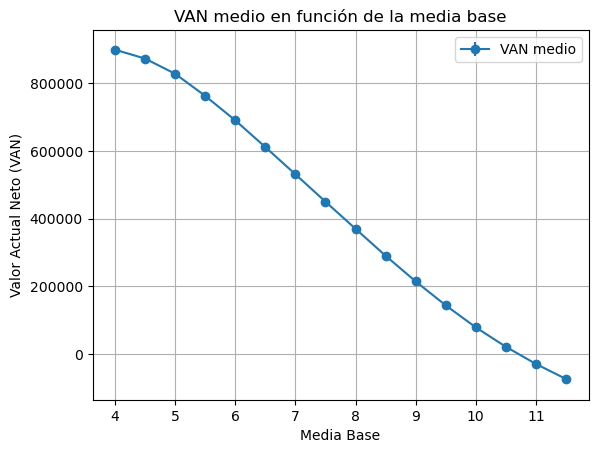

In [142]:
plt.errorbar(valores_media_base, van_por_valor, yerr=error_por_valor, fmt='-o', label='VAN medio')
plt.title('VAN medio en función de la media base')
plt.xlabel('Media Base')
plt.ylabel('Valor Actual Neto (VAN)')
plt.grid(True)
plt.legend()
plt.show()
